## 回测代码

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

def factor_group(factor, group_number=10):
    '''按照因子值分组,grp1最小'''
    fg = factor.apply(
        lambda x: pd.qcut(x.rank(method='first'), q=group_number, labels=False) + 1, 
        axis=1)
    def _factor_group(factor_daily:pd.Series):
        dic = {f'group{str(g_value)}':factor_daily[factor_daily == g_value].index.tolist() for g_value in range(1, 1+group_number)}
        return pd.Series(dic)
    
    return {'group_stock':fg.apply(_factor_group, axis=1), 'group_index':fg}

def group_backtest(price:pd.DataFrame, factor:pd.DataFrame, group_number=10):
    '''
    分组回测,日度调仓,所有股票等权买入(买入各个股票的价值相同)  

    Paras:
    price:日频价格数据,index:Date,
    factor:日度因子值,index:Date,
    group_number:分组数,默认值为10, 组数大的因子值大

    Return:
    index:日期, col:组别, value: 指定日期下指定组数的收益率
    '''

    if 'Date' in factor.columns:
        factor = factor.set_index('Date')
    elif 'date' in factor.columns:
        factor = factor.set_index('date')

    factor = factor.shift(1).iloc[1:] # 第i日的因子作为第i+1日对应股票的调仓依据
    
    ret = price / price.shift(1)
    ret = ret.loc[factor.index, factor.columns].fillna(1)

    fg = factor_group(factor, group_number=group_number)['group_index']
    
    dic = {}
    for g_value in tqdm(range(1, 1+group_number)):
        is_in_group = fg.applymap(lambda x: 1 if x == g_value else 0)
        group_ret_daily = (ret * is_in_group).sum(axis=1) / is_in_group.sum(axis=1)
        dic[f'group{g_value}'] = group_ret_daily

    g_ret = pd.DataFrame(dic)
    # g_ret['g_mean'] = g_ret.mean(axis=1)
    g_ret['benchmark'] = ret.mean(axis=1)

    return g_ret

def position_backtest(price:pd.DataFrame, position:pd.DataFrame):
        '''
        用仓位数据来进行回测,
        price:日度价格数据
        position:对应的日度股票持仓数量
        '''
        holding = price * position
        holding_all = holding.sum(axis=1)
        ret = holding_all / holding_all - 1

        return ret

def group_backtest_plot(price:pd.DataFrame, factor:pd.DataFrame, group_number=5, save_path=None, is_zz1000=False, gap=1):
    '''
    分组回测,日度调仓  
    Para:
    price:日频价格数据,index:Date,
    factor:日度因子值,index:Date,
    group_number:分组数,默认值为10, 组数大的因子值大
    '''

    if gap == 1:
        g_ret = group_backtest(price=price, factor=factor, group_number=group_number)
    else:
        g_ret = group_backtest_gapday(price=price, factor=factor, group_num=group_number, gap=gap) 

    g_ret.index = [str(i) for i in g_ret.index]
    g_ret_cumsum = g_ret.cumprod()

    if is_zz1000:
        index_data = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/index_data/close.csv')
        index_data.set_index('Unnamed: 0', inplace=True)
        zz1000 = index_data.loc[852, :]
        zz1000 = zz1000.loc[g_ret.index]
        zz1000_bt = zz1000 / zz1000.iloc[0]
        g_ret_cumsum['zz1000'] = zz1000_bt
    
    plt.style.use('seaborn')
    g_ret_cumsum.plot(figsize=(12, 6), linewidth=1)

    if is_zz1000:
        plt.plot(zz1000_bt, linewidth=2)

    plt.legend()

    if save_path is not None:
        plt.savefig(save_path, facecolor='white', dpi=300)
    plt.show()


def group_backtest_gapday(price:pd.DataFrame, factor:pd.DataFrame, group_num=5, gap=10):
    '''
    换仓期为gap日的回测系统
    '''

    def handle_factor(factor=factor, gap=gap):
        '''将因子值按gap日求平均得到新的间隔gap日的因子序列'''
        if 'Date' in factor.columns:
            factor.set_index('Date', inplace=True)
        elif 'date' in factor.columns:
            factor = factor.set_index('date')
        
        new_index = [factor.index[i] for i in range(0, len(factor.index), gap)]
        new_factor = pd.DataFrame(
            [factor.loc[new_index[i]:new_index[i+1]].mean() for i in range(len(new_index) - 1)], 
            index=new_index[:-1]
        )
        
        return new_factor, new_index
    
    new_factor, new_index = handle_factor(factor=factor)

    new_factor = ((new_factor.T - new_factor.T.mean()) / (new_factor.T.std() + 1e-10)).T.fillna(0)
    new_factor = new_factor.shift(1).iloc[1:].fillna(0)
    
    ret = pd.DataFrame(
        [price.loc[new_index[i]] / (price.loc[new_index[i-1]] + 1e-10) for i in range(1, len(new_index))],
        index=new_index[1:]
    )
    ret = ret.loc[new_factor.index, new_factor.columns].fillna(1)

    fg = factor_group(new_factor, group_number=group_num)['group_index']
    
    dic = {}
    for g_value in tqdm(range(1, 1+group_num)):
        is_in_group = fg.applymap(lambda x: 1 if x == g_value else 0)
        group_ret_daily = (ret * is_in_group).sum(axis=1) / is_in_group.sum(axis=1)
        dic[f'group{g_value}'] = group_ret_daily

    g_ret = pd.DataFrame(dic)
    g_ret['benchmark'] = ret.mean(axis=1)

    return g_ret

In [2]:
cd /mnt/datadisk2/aglv/aglv/lab_aglv/

/mnt/datadisk2/aglv/aglv/lab_aglv


In [3]:
from forintern.DataDaily import DataDaily

In [4]:
datadaily = DataDaily()
close = datadaily.adjclose

load ./data_daily.h5...


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


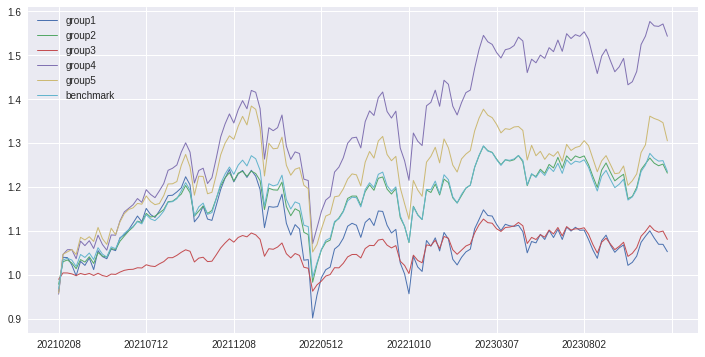

In [12]:
relu_nightret_vol_zs_r5 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/relu_nightret_r5mean_vol_zs_dot_r15.csv').iloc[20:]
group_backtest_plot(close, relu_nightret_vol_zs_r5, gap=5)

In [8]:
close2 = datadaily.close

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


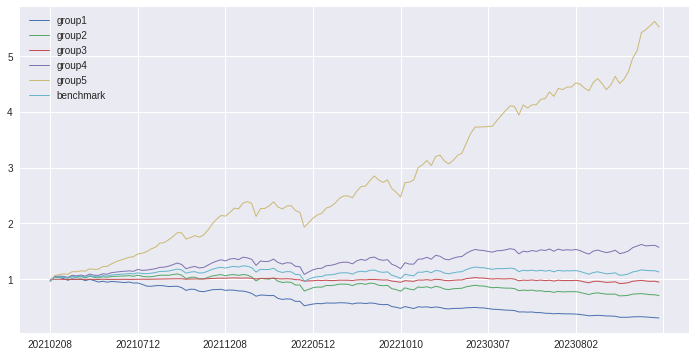

In [12]:
fa_p_vol_weight_v1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/price_vol_weight_corr_v2_ret0_r15_day.csv')
group_backtest_plot(close2, fa_p_vol_weight_v1.iloc[20:], gap=5)

100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


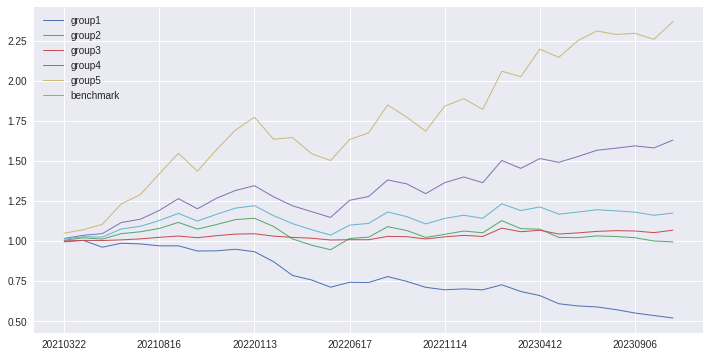

In [18]:
fa_close_vol_corr_shift = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/close_vol_shift_corr_cwin_15_swin_5.csv').iloc[30:, :]
group_backtest_plot(close, fa_close_vol_corr_shift, gap=20)

100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


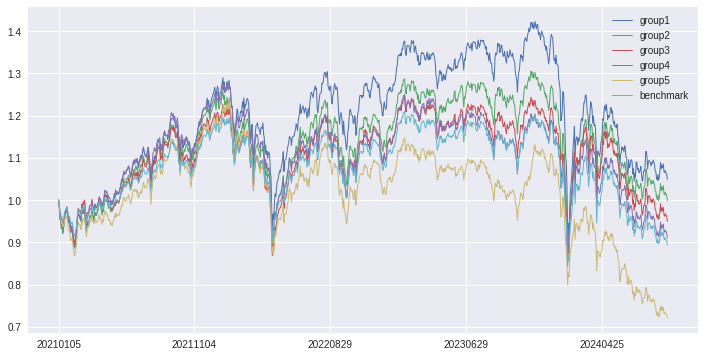

In [17]:
fa_p_vol_idxmax = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/pret_vol_idxmax_r15_daily.csv')
fa_p_vol_idxmax = fa_p_vol_idxmax.set_index('date')
group_backtest_plot(close, fa_p_vol_idxmax.loc[20210101:])

100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


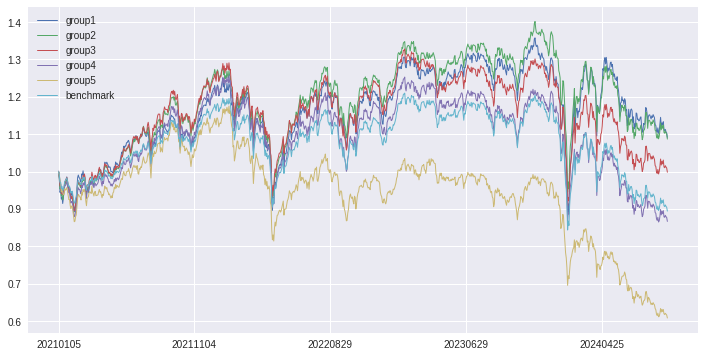

In [24]:
p_vol_corr_daily = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/pret_volret_corr_r15_daily.csv')
p_vol_corr_daily2 = p_vol_corr_daily.set_index('date')
group_backtest_plot(close, p_vol_corr_daily2.loc[20210101:])

100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


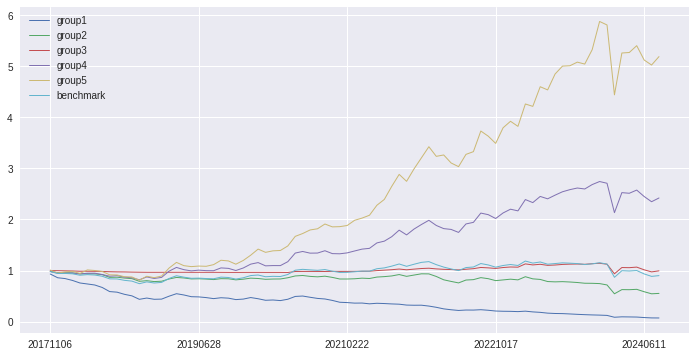

In [26]:
p_vol_corr_daily = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/p_vol_corr_r15_daily.csv')
p_vol_corr_daily2 = p_vol_corr_daily.set_index('date')
group_backtest_plot(close, p_vol_corr_daily2, gap=20)

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


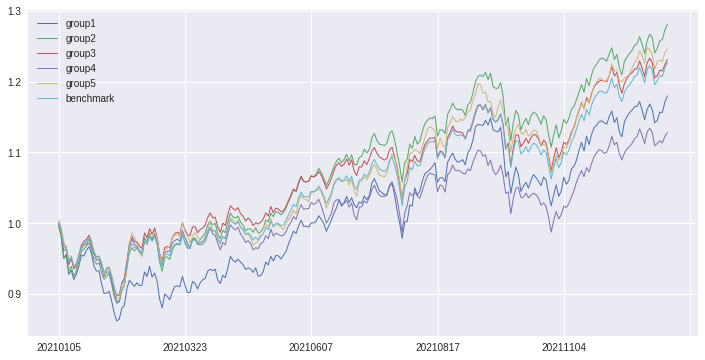

In [9]:
ret_turn_corr_agg10_21 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/ret_turn_corr_agg10_21_min.csv')
group_backtest_plot(close, ret_turn_corr_agg10_21)

100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


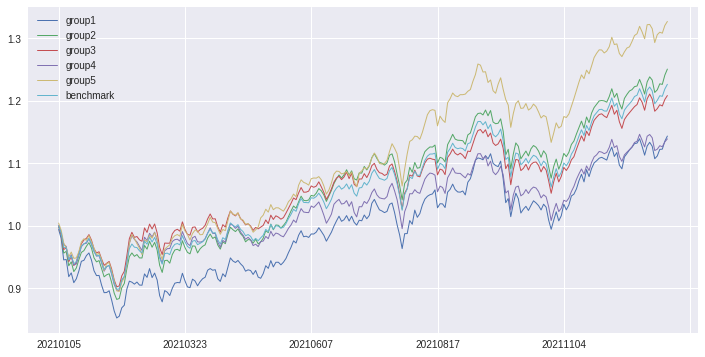

In [8]:
ret_turn_corr_21 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/ret_turn_corr_21_min.csv')
group_backtest_plot(close, ret_turn_corr_21)

100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


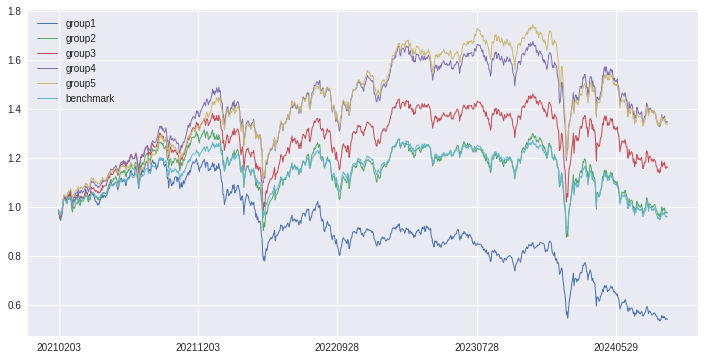

In [12]:
night_conti_1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/nightret_r3mean_conti_down_0.9_r20.csv.csv').iloc[21:]
group_backtest_plot(close, night_conti_1)

100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


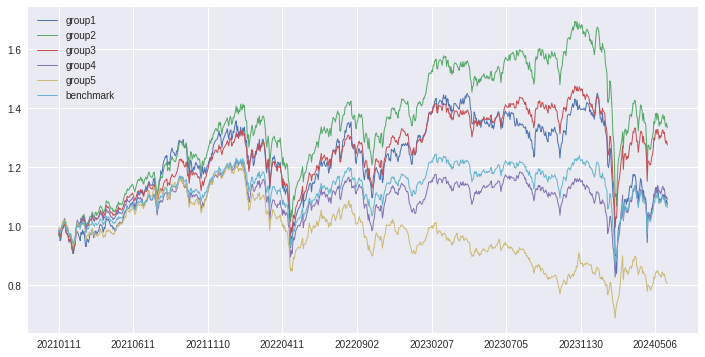

In [7]:
inday_ret = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/indayret_r3mean.csv').iloc[4:]
group_backtest_plot(close, inday_ret)

100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


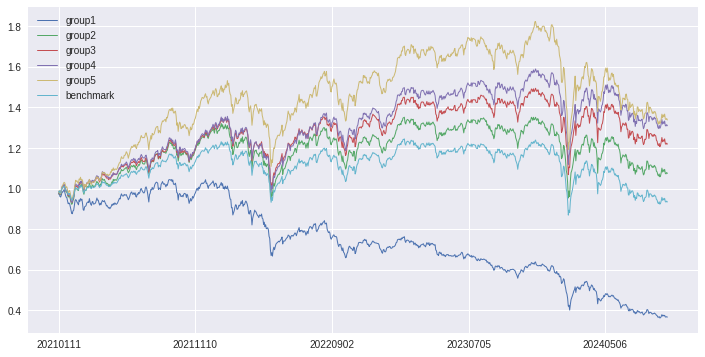

In [9]:
night_ret = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/nightret_r3mean.csv').iloc[4:]
group_backtest_plot(close, night_ret)

100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


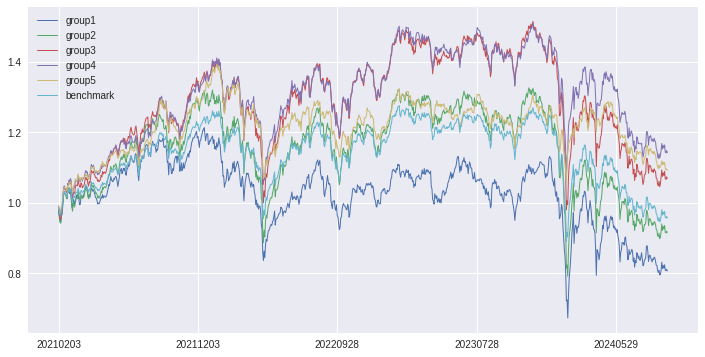

In [89]:
ret_conti_1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/ret_r3mean_conti_down_0.9_r20.csv.csv').iloc[21:]
group_backtest_plot(close, ret_conti_1)

100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


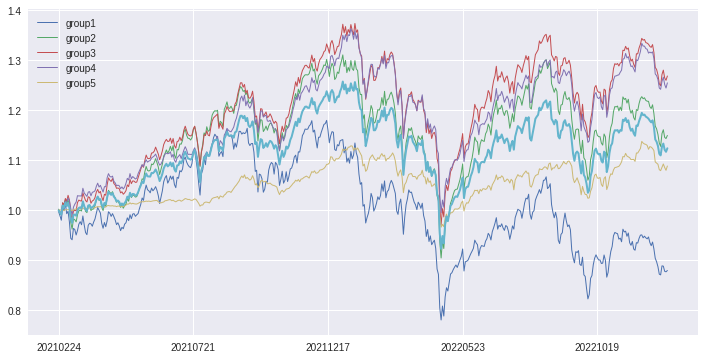

In [61]:
conti_2 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/asymmetric_factor/CVaR_neg_210101_230101_r30.csv')
conti_2 = conti_2.iloc[::-1].iloc[31:]
# conti_2
group_backtest_plot(close, conti_2)

100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


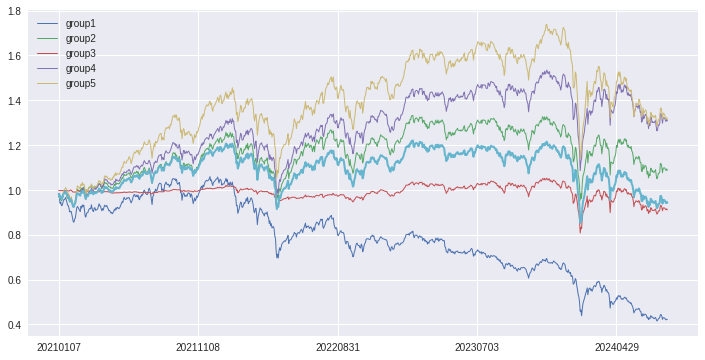

In [51]:
night_ret_1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/nightret_r3mean.csv').iloc[2:-20]
night_ret_1 = night_ret_1.set_index('date')
night_ret_1.index.names = ['Date']
night_ret_1_zs = ((night_ret_1.T - night_ret_1.T.mean()) / (night_ret_1.T.std() + 1e-10)).T
night_ret_1_zs = night_ret_1_zs.fillna(0)
group_backtest_plot(close, night_ret_1_zs)

100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


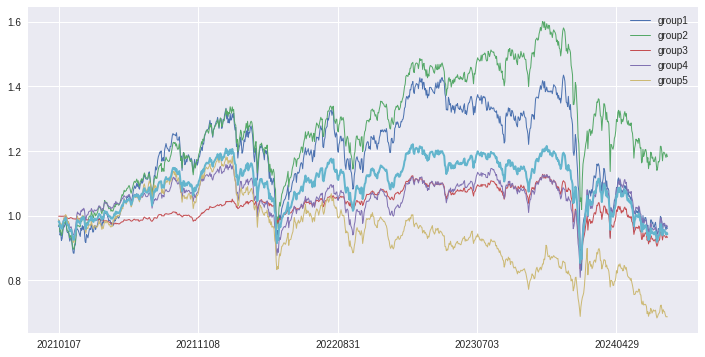

In [52]:
night_ret_1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/indayret_r3mean.csv').iloc[2:-20]
night_ret_1 = night_ret_1.set_index('date')
night_ret_1.index.names = ['Date']
night_ret_1_zs = ((night_ret_1.T - night_ret_1.T.mean()) / (night_ret_1.T.std() + 1e-10)).T
night_ret_1_zs = night_ret_1_zs.fillna(0)
group_backtest_plot(close, night_ret_1_zs)

100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


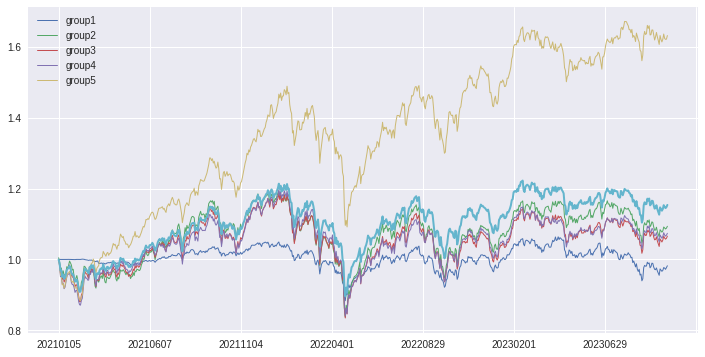

In [8]:
turnstd_v5_1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turn_diffabs_agg10min_noavg_21_23_min.csv')
group_backtest_plot(close, turnstd_v5_1)

100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


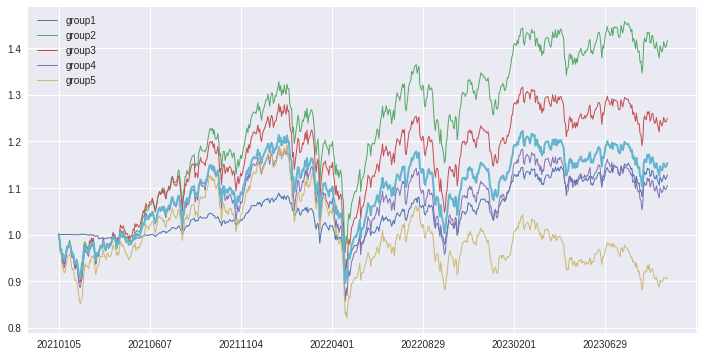

In [4]:
turnstd_v4_1 = pd.read_csv('aglv_factor/Sep/turnstd_agg5min_noavg_21_23_min.csv')
group_backtest_plot(close, turnstd_v4_1)

100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


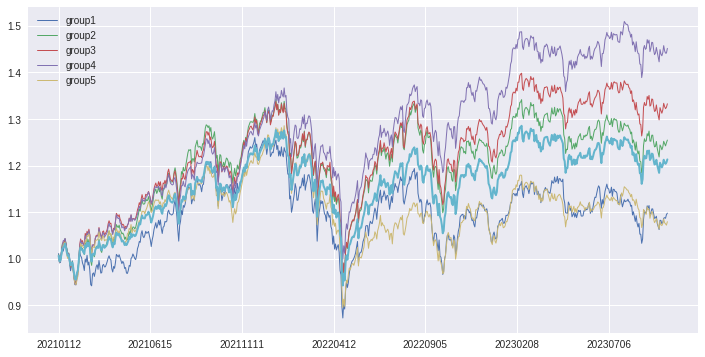

In [22]:
turn_fa_v3_nostop = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turnstd_r5mean_noavg_21_23_destop_min.csv')
# turn_fa_v3_nostop.index.names = ['Date']
group_backtest_plot(close, turn_fa_v3_nostop.iloc[5:, :])

100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


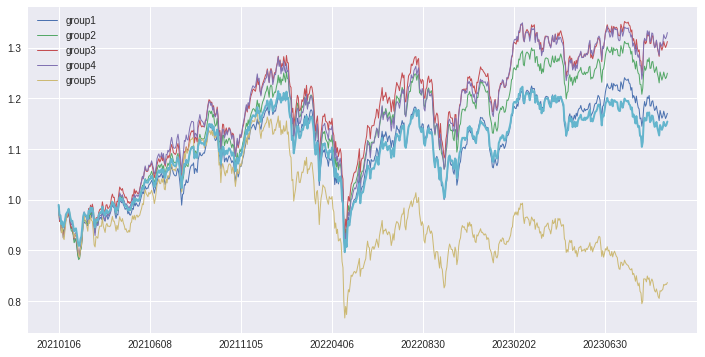

In [12]:
turn_cvar_posi_mul_ret_abs= pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turn_cvar_posi_mul-ret-abs_noavg_21_23_destop_min.csv')
# turn_cvar_posi_mul_ret_abs.index.names = ['Date']
group_backtest_plot(close, turn_cvar_posi_mul_ret_abs.iloc[1:, :])

100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


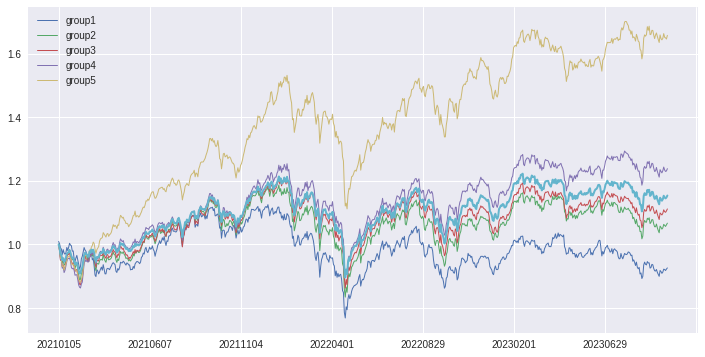

In [4]:
turn_cvar_posi_noavg_21_23_min = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turn_cvar_posi_noavg_21_23_min.csv')
group_backtest_plot(close, turn_cvar_posi_noavg_21_23_min)

100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


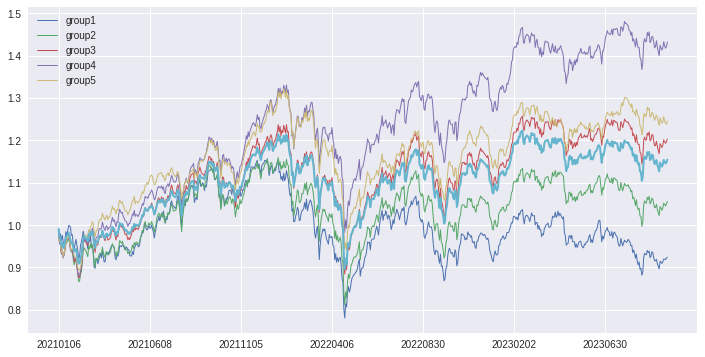

In [6]:
turn_cvar_posi_noavg_21_23_destop_min = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turn_cvar_posi_noavg_21_23_destop_min.csv')
group_backtest_plot(close, turn_cvar_posi_noavg_21_23_destop_min.iloc[1:, :])

100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


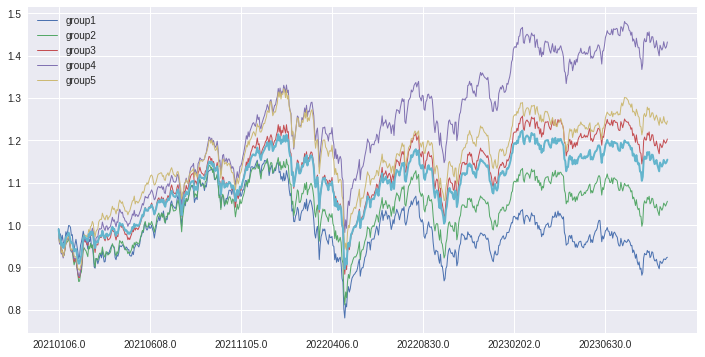

In [7]:
group_backtest_plot(close, turn_cvar_posi_noavg_21_23_destop_min.shift(-1).iloc[:-1, :])

In [ ]:
root = '/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/factor_829/inaday_cvar_neg_0.9_21_23_min.csv'
f1 = pd.read_csv(root)

In [ ]:
group_backtest_plot(close, f1)

In [ ]:
root2 = '/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/factor_829/longshort_v3_vol_ret_w15_21_23_min.csv'
f2 = pd.read_csv(root2)
group_backtest_plot(close, f2)

In [ ]:
f3 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/factor_829/conti_up_T30_21_23_min.csv')
group_backtest_plot(close, f3)

In [ ]:
close

In [ ]:
turnstd_noavg = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turnstd_noavg_min.csv')
group_backtest_plot(close, turnstd_noavg)

In [ ]:
turnstd_avg20 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turnstd_avg20d_min.csv')
group_backtest_plot(close, turnstd_avg20.iloc[20:])

In [ ]:
turn_std_21_23 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turnstd_noavg_21_23min.csv')
group_backtest_plot(close, turn_std_21_23)

In [ ]:
turn_std_21_23_avg = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turnstd_avg20d_21_23min.csv')
group_backtest_plot(close, turn_std_21_23_avg.iloc[20:])

In [ ]:
turn_std_21_23_destop = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turnstd_noavg_destiop_min.csv')
group_backtest_plot(close, turn_std_21_23_destop, group_number=10)